In [50]:
from model import  * 
import time
from self_pack import self_made
import torch.nn as nn
import torch.optim as optim

batch_size = 64
num_points = 64 * 8
num_labels = 1
loss = []
Accu = []
def main_(path_1,path_2,epoch):
    pointnet = PointNet(num_points, num_labels)

    #new_param = pointnet.state_dict()
    #new_param['main.0.main.6.bias'] = torch.eye(3, 3).view(-1)
    #new_param['main.3.main.6.bias'] = torch.eye(64,64).view(-1)
    #pointnet.load_state_dict(new_param)
    pointnet.load_state_dict(torch.load('./models/human_wall_95_40.pth'))
    criterion = nn.BCELoss()
    optimizer = optim.Adam(pointnet.parameters(), lr=0.001)
    times = [0]
    for _ in range(epoch+1):
        s = time.time()
        pointnet.zero_grad()
        input_data, labels = self_made.data_sampler(path_1,path_2)
        #input_data, labels = data_sampler(batch_size, num_points)

        output = pointnet(input_data)
        output = nn.Sigmoid()(output)

        error = criterion(output, labels)
        error.backward()

        optimizer.step()

        with torch.no_grad():
            output[output > 0.5] = 1
            output[output < 0.5] = 0
            accuracy = (output==labels).sum().item()/batch_size
        f = time.time()
        loss.append(float(error.item()))
        Accu.append(float(accuracy))
        times.append(times[-1] + f-s)
        #if iteration % 10 == 0:

            #print('Iteration : {}   Loss : {}'.format(iteration, error.item()))
            #print('Iteration : {}   Accuracy : {}'.format(iteration, accuracy))
    #torch.save(pointnet.state_dict(), './model_2.pth')
    return pointnet,times

In [51]:
#電源接続していないときは遅いね
#電源関係あるのかな？


import time 
from self_pack import self_made
import torch
#s = time.time()
pointnet,times = main_('./normalize_txt/40_95/test_human/*','./normalize_txt/40_95/test_wall/*',10)
#torch.save(pointnet.state_dict(), './human_wall.pth')
#takuya/* と tree/*で再度モデルの作成→保存のやり直し
#f = time.time()
#print(f-s)

In [48]:
#torch.save(pointnet.state_dict(), './models/human_wall_95_40.pth')

In [29]:
print('Accuracy is {} %'.format(max(Accu)))

Accuracy is 1.0 %


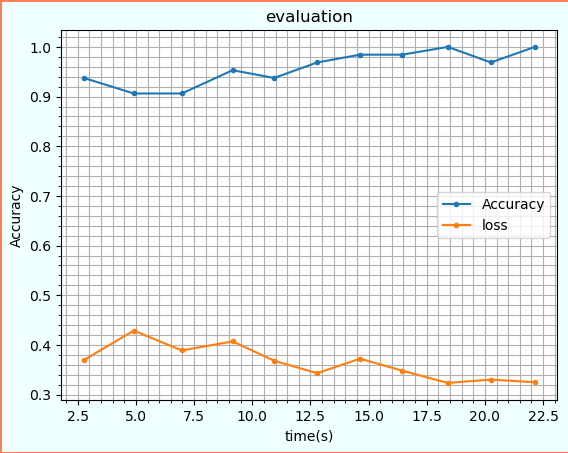

In [52]:
import matplotlib.pyplot as plt
x = range(0,len(Accu)+1)
ti = []
n = 0
plt.figure(facecolor="azure", edgecolor="coral", linewidth=2)
plt.plot(times[1:],Accu,marker='.',label='Accuracy')
plt.plot(times[1:],loss,marker='.',label='loss')
plt.xlabel('time(s)')
plt.ylabel('Accuracy')
plt.title('evaluation')
plt.minorticks_on()
plt.grid(which='both')
plt.legend()

In [45]:
len(times)

52

In [46]:
len(Accu)

51